In [1]:
import numpy as np
import math
import pandas as pd
import numpy.random as rand
import matplotlib.pyplot as plt
from scipy import signal
import scipy.stats as stats
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa import api as tsa
from scipy.stats import skew, kurtosis
import h5py
import warnings
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU
import pywt
%matplotlib inline
import random
import itertools
from tqdm import tqdm
import time

In [ ]:
"""#Запись временного ряда

t= np.linspace(0, 1, 1024*10)
y = np.sin(t)+np.cos(50*t)+np.random.random(1024*10)
#t= np.linspace(0, 1, 24)
#y=np.array([12.60, 18.92, 17.08, 15.51, 8.97, 14.52, 12.77, 12.96, 5.55, 11.09, 9.23, 5.03, 2.15, 8.95, 8.04, 5.68, 0.14, 5.85, 4.21, 2.56, 0.08, 3.87, 1.10, 0.85])
#Строим график ВР
plt.figure(figsize = (10, 5))
plt.plot(t, y)
plt.title("График ВР")
plt.ylabel('y(t)')
plt.xlabel('t [sec]')
plt.show()"""

In [2]:
#Shannon Entropy Excess
alp=[]
h=[]
for i in range(1,10): 
    alp.append(i+1)
    h.append(np.log(i+1)-np.log(i))
print (alp, h)

[2, 3, 4, 5, 6, 7, 8, 9, 10] [0.6931471805599453, 0.4054651081081645, 0.2876820724517808, 0.2231435513142097, 0.18232155679395468, 0.15415067982725827, 0.13353139262452252, 0.11778303565638382, 0.10536051565782634]


In [3]:
#Maximum Shannon entropy
H=[]
H.append(np.log(alp[0]))
for i in range(1,9):
    H.append((np.log(alp[i])))
print (alp, H)

[2, 3, 4, 5, 6, 7, 8, 9, 10] [0.6931471805599453, 1.0986122886681098, 1.3862943611198906, 1.6094379124341003, 1.791759469228055, 1.9459101490553132, 2.0794415416798357, 2.1972245773362196, 2.302585092994046]


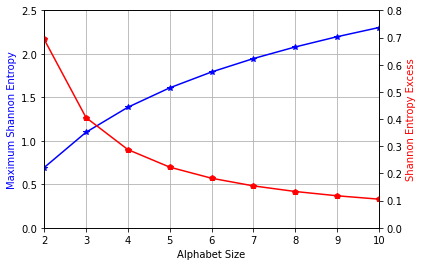

In [4]:
#Maximum Shannon entropy (shown by blue square) and entropy excess (shown by red triangle) for different alphabet sizes. 
#The unit for each of Shannon entropy and entropy excess is the natural unit of information (i.e., nat).

fig = plt.figure()

ax = fig.add_subplot() # Primary y
ax2 = ax.twinx() # Secondary y

# Plot variables
ax.plot(alp, H, color='blue', marker='*', label="Maximum Shannon Entropy")

ax2.plot(alp, h, color='red', marker='p', label="Shannon Entropy Excess")

# Custom ylimit
ax.set_ylim(0,2.5)
ax2.set_ylim(0,0.8)
ax.set_xlim(2,10)
ax.set_xlabel("Alphabet Size")
ax.set_ylabel("Maximum Shannon Entropy", color='blue')
ax2.set_ylabel("Shannon Entropy Excess", color='red')
ax.grid(True)

In [5]:
#Algorithm 1 Maximum Entropy Partitioning
#Require: Finite-length time series X and alphabet size |∑|.

#Параметр Alphabet_size не должен превышать размер временного ряда!

#X - временной ряд
#Alphabet_size - размер алфавита

def Algoritm_1 (X, Alphabet_size):
    #Ensure: Partition position vector P
    P=np.zeros(Alphabet_size+1)

    #1. Sort the time series X in the ascending order;
    X=sorted(X)
    #2. Let K=length(X), which is the length of the time series;
    K=len(X)
    #3. Assign P(1) = X(1), i.e., the minimum element of X
    P[0]=X[0]
    #4.
    for i in range (1, Alphabet_size):
        #print(math.ceil((i)*K/Alphabet_size))
        P[i]=X[math.ceil((i)*K/Alphabet_size)]
    #5. Assign P(|∑| + 1) = X(K), i.e., the maximum element of X
    P[Alphabet_size]=X[K-1]
    return(P)

In [ ]:
"""Alphabet_size=22
P=Algoritm_1(y,Alphabet_size)
print('Partition position vector:\n', P)"""

In [ ]:
"""plt.plot(t, y, marker='.')
for i in range (Alphabet_size+1):
    plt.axhline(y=P[i], xmin=min(t), xmax=max(t), color="red", linestyle = '--')
plt.title("График ВР")
plt.ylabel('y(t)')
plt.xlabel('t [sec]')
plt.show()"""

In [6]:
#Time-series to sumbols

#y - временной ряд
#P - Partition position vector
#Alphabet_size - размерность алфавита

def TTS (y, P, Alphabet_size):
    English_Alphabet='abcdefghijklmnopqrstuvwxyz'
    s=[]
    Num_levels=Alphabet_size+1
    for i in range (len(y)):
        for j in range (1, Num_levels):
            #print(j)
            if (y[i]<P[j]) and (y[i]>=P[j-1]):
                s.append(English_Alphabet[j-1])
        if (y[i]==P[Num_levels-1]):
            s.append(English_Alphabet[Alphabet_size-1])    
    S=''.join(map(str,s)) #склейка массива символов в одну строку
    #print (s)
    #print('S ', S)
    return(S)

In [ ]:
#Преобразование временного ряда в ряд символов
#S=TTS(y, P, Alphabet_size)

In [ ]:
#print(S)

In [ ]:
#print('Длина временного ряда =', len(y))
#print('Количество символов =', len(S))

In [7]:
#Вычисление энтропии

#Функция Generator_1 позволяет сгенерировать возможные комбинации из символов алфавита (Alphabet_size) заданной длины K 
#(используется на начальной итерации)

def Generator_1 (Alphabet_size, K): #K-длина комбинации символов
    English_Alphabet='abcdefghijklmnopqrstuvwxyz'
    A_symb=English_Alphabet[0:Alphabet_size]
    #print ('Alphabet: ', A_symb)
    comb_set = itertools.combinations_with_replacement(A_symb*10, K)
    m=[]
    for val in comb_set: 
        m.append(''.join(map(str,val)))
    m=list(set(m))
    m.sort()
    m=np.array(m, str)
    #print('\nВозможные комбинации символов sq_i\n')
    #print (m)
    #print('\nКоличество комбинаций:', len(m))
    return(m)

#Функция Generator_2 изпользуется в последующих итерациях алгоритма 2 для генерации последовательностей типа sigma\q_i 
#(в формуле отношения энтропий из алгоритма 2 - это комбинации для знаменателя)   

#Q - набор состояний
#Alphabet_size - размерность алфавита

def Generator_2(Q, Alphabet_size): #Для знаменателя    
    English_Alphabet='abcdefghijklmnopqrstuvwxyz'
    #A_symb=English_Alphabet[0:Alphabet_size]
    #print ('Generator2')
    #comb_set = itertools.combinations_with_replacement(Q1[1]+A_symb, 2)
    m=[]
    for i in range(len(Q)): 
        for j in range(Alphabet_size):
            #print(i,j)
            m.append(Q[i]+English_Alphabet[j])
    #m=list(set(m))
    #m.sort()
    m=np.array(m, str)
    #print('\nВозможные комбинации символов sq_i\n')
    #print (m)
    #print('\nКоличество комбинаций:', len(m)) 
    return(m)

#Функция Generator_3 изпользуется в последующих итерациях алгоритма 2 для генерации последовательностей типа sigma\sq_i 
#(в формуле отношения энтропий из алгоритма 2 - это комбинации для числителя)   

#m - комбинации символов, которые были сгенерированы с помощью Generator_2
#Alphabet_size - размерность алфавита

def Generator_3(m, Alphabet_size):#Для числителя   
    English_Alphabet='abcdefghijklmnopqrstuvwxyz'
    #A_symb=English_Alphabet[0:Alphabet_size]
    #print ('Generator3')
    #comb_set = itertools.combinations_with_replacement(Q1[1]+A_symb, 2)
    k=[]
    for i in range(len(m)): 
        for j in range(Alphabet_size):
            #print(i,j)
            k.append(English_Alphabet[j]+m[i])
    #m=list(set(m))
    #m.sort()
    k=np.array(k, str)
    #print('\nВозможные комбинации символов sq_i\n')
    #print (k)
    #print('\nКоличество комбинаций:', len(k))
    return(k)

# Функция Entropy_2 используется для вычисления энтропии в алгоритме 2

#Q - набор состояний
#m - сгенерированные комбинации с попощью функций Generator (1-3) 
#h - параметр для сортировки в функции funcSort (0 - сортировка по нулевому элементу строки (исп. для знаменателя), 
#1 - сортировка по первому элементу строки (исп. для числителя))
#sr - тип сортировки (1 и 2)
#S - строка символов
#Alphabet_size - размерность алфавита

def Entropy_2 (Q, m, h, sr, S, Alphabet_size):
    def funcSort(x): #Функция для правильной сортировки комбинаций символов
        return x[h]
    if (sr==1):
        #Сортировка №1 (используется на первой итерации алгоритма 2)
        aia1=np.hsplit(np.array(sorted(m, key=funcSort)), len(Q))
        aia1=np.array(np.mat(aia1))
        #print('\nРезультат сортировки1 комбинаций sq_i\n')
        #print (aia1)
    else:
        #Сортировка №2 (используется на последущих итерациях алгоритма 2)
        aia1=np.hsplit(np.array(m), len(Q))
        aia1=np.array(np.mat(aia1))
        #print('\nРезультат сортировки2 комбинаций sq_i\n')
        #print (aia1)

    #Считаем сколько раз в строке S встречается каждая комбинация символов
    uiu1=np.zeros((np.shape(aia1)[0], np.shape(aia1)[1]), int)
    for i in range (np.shape(aia1)[0]):
        for j in range (np.shape(aia1)[1]):
            uiu1[i][j]=(S.count(aia1[i][j]))
    #print('\nКоличество найденных комбинаций в строке S\n')
    #print(uiu1)
    
    #Вычисление вероятностей
    prob1=np.zeros((np.shape(uiu1)[0], np.shape(uiu1)[1]), float)
    for i in range (np.shape(uiu1)[0]):
        for j in range (np.shape(uiu1)[1]):
            prob1[i][j]=(1+uiu1[i][j])/(np.sum(uiu1[i])+Alphabet_size)
    #print('\nМатрица вероятностей\n')
    #print(prob1)
    
    #Не всегда сумма вероятностей в строке равна 1 ?????------------------------
    
    #Нормировка вероятностей
    prob2=np.zeros((np.shape(prob1)[0], np.shape(prob1)[1]), float)
    for i in range (np.shape(prob1)[0]):
        prob2[i]=prob1[i]/(np.sum(prob1[i]))
    #print('\nНормированная вероятность\n', prob2, '\n')
    
    #Вычисление энтропии (!!!с нормированной вероятностью!!!)
    Ent1=np.zeros(np.shape(prob1)[0])
    for i in range (np.shape(prob1)[0]):
        for j in range (np.shape(prob1)[1]):
            Ent1[i]=Ent1[i]-prob2[i][j]*np.log(prob2[i][j])
    #print('\nЭнтропия\n')
    #print(Ent1)
    
    return(Ent1, prob2, aia1)    

In [8]:
#Вероятность состояния P(q_i) (возможно применение для P(sigma_i))

#Q - набор состояний
#S - строка символов

def probability_2 (Q, S):
    nn=np.zeros(len(Q), int)
    for i in range (len(Q)):
        nn[i]=(S.count(Q[i]))
    #print(nn)
    pp=nn/np.sum(nn)
    #print (pp)
    return(pp)

In [9]:
'''def pp_2(pp):
    pp2=np.zeros((np.shape(pp)[0], int(np.shape(pp)[1]/3)), float)
    for i in range (np.shape(pp)[0]):
        for j in range (int(np.shape(pp)[1]/3)):
            #print(i, 3*j, 3*j+3)
            pp2[i][j]=np.sum(pp[i][3*j:3*j+3])
    print('\npp2\n', pp2, '\n')
    print(pp[0][0]+pp[0][1]+pp[0][2])
    print(pp[0][3]+pp[0][4]+pp[0][5])
    print(pp[0][6]+pp[0][7]+pp[0][8])
    return(pp2)
'''

#Функция mt_2 используется для генерации матрицы возможных состояний типа sq_i 
#(убирается с конца элемент sigma + исключаются повторяющиеся комбинации (из матрицы aia1 функции Entropy_2))

#mat - матрица комбинаций из функции Entropy_2

def mt_2 (mat):
    for i in range (np.shape(mat)[0]):
        for j in range (int(np.shape(mat)[1])):
            mat[i][j]=mat[i][j][:-1]
    #print('\nmat_2\n', mat, '\n')
    mt=[]
    for i in range (np.shape(mat)[0]):
        mt.append(sorted(set(mat[i])))
    mt=np.array(mt, str)
    #print('\nmt\n', mt, '\n')
    return (mt)

#Algorithm 2 State Splitting for Variable-Depth D-Markov Machine

#S - строка символов
#Alphabet_size - размерность алфавита
#Eps_p - Пороговое значение для вероятности возникновения состояния, 
#указывающее, имеет ли состояние релевантную статистическую информацию или нет. 
#Eps_q - Порог для условного уменьшения энтропии, который определяет, нужны ли состояния с более длительной памятью или нет.

def Algoritm_2(S, Alphabet_size, Eps_p, Eps_q):
    
    English_Alphabet='abcdefghijklmnopqrstuvwxyz'
    
    #Initialize (на начальном этапе состояния Q соответствуют буквам алфавита (размером - Alphabet_size))
    Alphabet=list(English_Alphabet[0:Alphabet_size])
    Q_1=np.array(Alphabet)
    #print (Q_1, '\n')

    #Entropy_2 (Q, m, h, sr, S, Alphabet_size):
    #Generator_1 (Alphabet_size, K)
    #Generator_2(Q, Alphabet_size):
    #Generator_3(m, Alphabet_size):   
    
    ii=0

    while 1:
        #print('\nИтерация:', ii, '\n')
        Q=Q_1
        
        if ii==0:
            #Числитель
            E_n=Entropy_2(Q, Generator_1 (Alphabet_size, 3), 1, 1, S, Alphabet_size)
            #Знаменатель
            E_d=Entropy_2(Q, Generator_1 (Alphabet_size, 2), 0, 1, S, Alphabet_size)
        else:
            mm=Generator_2 (Q, Alphabet_size)
            E_d=Entropy_2(Q, mm, 0, 2, S, Alphabet_size)
            E_n=Entropy_2(Q, Generator_3 (mm, Alphabet_size), 0, 2, S, Alphabet_size)  
        
        Ent_numerator=E_n[0] #Энтропия числитель
        Ent_denominator=E_d[0] #Энтропия знаменатель
        prob=probability_2(Q, S) #Вероятность P(q_i)
        prob2=E_d[1] #Вероятность P(sigma|q_i)
        mat=np.array(E_n[2]) #Матрица состояний (s-q_i-sigma)
        #print('\nmat', mat, '\n')
        mt=mt_2(mat) #Матрица состояний (s-q_i)
        for i in range (len(Q)):
            #print("*****",(Ent_numerator[i]/Ent_denominator[i]), '<', Eps_q, ' ', prob[i], '>', Eps_p, '*******')
            if ((Ent_numerator[i]/Ent_denominator[i])<Eps_q) and (prob[i]>Eps_p):
                #print('true')
                Q_1=np.delete(Q_1, list(Q_1).index(Q[i])) #Удаляем из множества состояний Q сотсояние q_i 
                Q_1=np.append(Q_1, mt[i]) #Добавляем к множеству состояний Q множество состояний sq_i
                #np.random.choice(mt[i], p=pp2[i]) #replace=True,
        #print('Q', Q, '\n')
        #print('Q_1', Q_1, '\n')
        #print('ii=', ii, '\n')        
        
        if (len(Q)==len(Q_1)):
            #print(ii, len(Q), len(Q_1)) 
            break
        ii=ii+1
    return (Q, prob, prob2)

In [ ]:
#Q=Algoritm_2(S)
#Q_1=Algoritm_2(S)[1]

In [ ]:
#print('Q=',Q)
#print('Q1=',Q_1)

In [10]:
#Функиця Information предназначена для вычисления взаимной информации I(n, P, Q) из алгоритма 3

#S - строка символов
#Q - набор состояний
#alp_size - размерность алфавита
#prob - Вероятность P(q_i) (из алгоритма 2)
#prob2 - #Вероятность P(sigma|q_i) (из алгоритма 2)

def Information (S, Q, alp_size, prob, prob2): 
    
    #Считаем сколько раз в строке S встречается каждая буква алфавита
    English_Alphabet='abcdefghijklmnopqrstuvwxyz'
    Alphabet=list(English_Alphabet[0:alp_size])
    prob_alp=probability_2 (Alphabet, S) #Вероятность P(sigma_j)
    print('prob_alp', prob_alp)
    
    #Вычисление энтропии (алфавит)
    Ent_alp=0
    for i in range (len(prob_alp)):
        Ent_alp=Ent_alp-prob_alp[i]*np.log(prob_alp[i])
        print('\\nЭнтропия алфавит\\n')
        print(Ent_alp)
        
    #Вычисление энтропии (состояния)
    Ent2=0
    Ent1=np.zeros(len(Q))
    for i in range (len(Q)):
        for j in range (alp_size):
            Ent1[i]=Ent1[i]-prob[i]*prob2[i][j]*np.log(prob2[i][j])
    Ent2=np.sum(Ent1)
    #print('\\nЭнтропия состояния\\n')
    #print(Ent2)
        
    #Вычисление взаимной информации I\n",
    I=0
    I=Ent_alp-Ent2

    #print('\\nВзаимная информация\\n')
    #print(I)
    return (I)

In [23]:
#Algoritm 3: Partitioning by Sequential Selection Based on an Information-Theoretic Measure

#X - временной ряд
#Al_size - размерность алфавита
#m - number of candidate partitioning locations

def Algoritm_3 (X, Al_size, m):
    
    #Пороги для алгоритма 2!!!
    Eps_p=0
    Eps_q=1
    
    #Create the set of candidate partitioning locations C via MEP in Algorithm 1.
    C=Algoritm_1(X, m)
    #Не рассматриваются 1-е и последнее значение С, т.к. это те же max(X) и min(X)
    C=np.delete(C, list(C).index(min(C)))
    C=np.delete(C, list(C).index(max(C)))
    
    #Assign the partitioning location vector
    P=np.zeros(Al_size, dtype=list)
    P[0]=[]
    P[0].append(min(X))
    P[0].append(max(X))

    #QQ=np.zeros(Al_size-1, dtype=list)
    QQ=[]
    Q_opt=[]
    
    I_opt=[] 
    I=[]
    p_c=[]
    
    for i in range tqdm(1, Al_size):
        #print('i_alg3 ',i)
        I.clear()
        QQ.clear()
        opti=0
        for j in range (len(C)):  
            p_c.clear()
            p_c.extend(P[i-1])
            p_c.append(C[j])
            p_c.sort()
            #print('p_c ', p_c)
            als=i+1 #размерность алфавита на данной итерации
            S=TTS(X, p_c, als)
            #print('S ',S)
            [Q, prob, prob2]=Algoritm_2(S, als, Eps_p, Eps_q)
            #print('Q ',Q)
            QQ.append(Q)
            #print('prob ',prob)
            #print('prob2 ',prob2)
            I.append(Information (S, Q, als, prob, prob2))
            #print('I ',I)
        opti=(I.index(max(I)))
        I_opt.append(I[opti])
        Q_opt.append(QQ[opti])
        #print('opt_I ', opti, 'max I', max(I), 'I_opt', )
        P[i]=[]
        P[i].extend(P[i-1])
        P[i].append(C[opti])
        P[i].sort()
        #P[i]=np.append(P[i], P[i-1]) 
        #print('P[i] ',P[i])
        C=np.delete(C, list(C).index(C[opti]))
        #print('C new ', C)
    return(P, I_opt, Q_opt)

In [24]:
#Algoritm_4 (Subtask 3): Determine the Alphabet Size

#I_opt - максимальные значения взаимной информации для I(n, P, Q)
#n - максимально возможная размарность алфавита (в данном случае не превышает len(I_opt))
#Eps_alp - пороговое значение (параметр предварительно определен)

def Algoritm_4 (I_opt, Eps_alp):
    I1=[]
    A=[]
    I2=[]
    for i in range(len(I_opt)-1):
        print('aaa', i, I_opt[i+1]/I_opt[i])
        I2.append(I_opt[i+1]/I_opt[i])
        if ((I_opt[i+1]/I_opt[i]) < Eps_alp):
            I1.append(I_opt[i+1]/I_opt[i])
            A.append(i+2)
            print (i, I_opt[i+1]/I_opt[i],  A)
    min_A=min(A)
    return (I2, min_A)
            

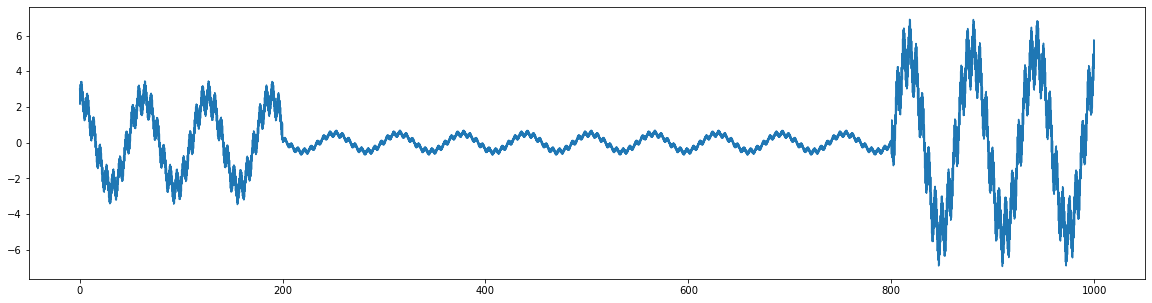

In [25]:
xs = np.linspace(0, 1000, 10000)
ys = np.sin(xs) + np.cos(0.1*xs)*5 + np.cos(10*xs)
ys = ys * [1 if x>200 else 5 for x in xs]
ys = ys * [1 if x>800 else 0.1 for x in xs]
plt.figure(figsize=[20, 5])
plt.plot(xs, ys)
plt.show()

In [26]:
[P_lo, I_lo, Q_lo]=Algoritm_3 (ys, 15, 50)

prob_alp [0.02 0.98]
\nЭнтропия алфавит\n
0.07824046010856292
\nЭнтропия алфавит\n
0.098039113279732
prob_alp [0.04 0.96]
\nЭнтропия алфавит\n
0.128755032994728
\nЭнтропия алфавит\n
0.167944147734173
prob_alp [0.06 0.94]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.22696752250060448
prob_alp [0.08 0.92]
\nЭнтропия алфавит\n
0.20205829154466046
\nЭнтропия алфавит\n
0.2787693717685874
prob_alp [0.1 0.9]
\nЭнтропия алфавит\n
0.23025850929940456
\nЭнтропия алфавит\n
0.3250829733914482
prob_alp [0.12 0.88]
\nЭнтропия алфавит\n
0.2544316243440109
\nЭнтропия алфавит\n
0.3669249912727096
prob_alp [0.14 0.86]
\nЭнтропия алфавит\n
0.2752557998921966
\nЭнтропия алфавит\n
0.40496348506393853
prob_alp [0.16 0.84]
\nЭнтропия алфавит\n
0.29321303419972966
\nЭнтропия алфавит\n
0.439669879401343
prob_alp [0.18 0.82]
\nЭнтропия алфавит\n
0.30866371705654677
\nЭнтропия алфавит\n
0.4713934868100942
prob_alp [0.2 0.8]
\nЭнтропия алфавит\n
0.3218875824868201
\nЭнтропия алфавит\n
0.50040242

prob_alp [0.5  0.06 0.44]
\nЭнтропия алфавит\n
0.34657359027997264
\nЭнтропия алфавит\n
0.5153782332855749
\nЭнтропия алфавит\n
0.8766096761963001
prob_alp [0.5  0.08 0.42]
\nЭнтропия алфавит\n
0.34657359027997264
\nЭнтропия алфавит\n
0.5486318818246331
\nЭнтропия алфавит\n
0.9129821202606168
prob_alp [0.5 0.1 0.4]
\nЭнтропия алфавит\n
0.34657359027997264
\nЭнтропия алфавит\n
0.5768320995793772
\nЭнтропия алфавит\n
0.9433483923290392
prob_alp [0.5  0.12 0.38]
\nЭнтропия алфавит\n
0.34657359027997264
\nЭнтропия алфавит\n
0.6010052146239835
\nЭнтропия алфавит\n
0.9686871446034316
prob_alp [0.5  0.14 0.36]
\nЭнтропия алфавит\n
0.34657359027997264
\nЭнтропия алфавит\n
0.6218293901721692
\nЭнтропия алфавит\n
0.9896238392836825
prob_alp [0.5  0.16 0.34]
\nЭнтропия алфавит\n
0.34657359027997264
\nЭнтропия алфавит\n
0.6397866244797024
\nЭнтропия алфавит\n
1.0065819093461585
prob_alp [0.5  0.18 0.32]
\nЭнтропия алфавит\n
0.34657359027997264
\nЭнтропия алфавит\n
0.6552373073365194
\nЭнтропия алф

prob_alp [0.5  0.08 0.24 0.18]
\nЭнтропия алфавит\n
0.34657359027997264
\nЭнтропия алфавит\n
0.5486318818246331
\nЭнтропия алфавит\n
0.8911398071782681
\nЭнтропия алфавит\n
1.1998035242348148
prob_alp [0.5  0.1  0.22 0.18]
\nЭнтропия алфавит\n
0.34657359027997264
\nЭнтропия алфавит\n
0.5768320995793772
\nЭнтропия алфавит\n
0.9099402007579278
\nЭнтропия алфавит\n
1.2186039178144745
prob_alp [0.5  0.12 0.2  0.18]
\nЭнтропия алфавит\n
0.34657359027997264
\nЭнтропия алфавит\n
0.6010052146239835
\nЭнтропия алфавит\n
0.9228927971108036
\nЭнтропия алфавит\n
1.2315565141673503
prob_alp [0.5  0.14 0.18 0.18]
\nЭнтропия алфавит\n
0.34657359027997264
\nЭнтропия алфавит\n
0.6218293901721692
\nЭнтропия алфавит\n
0.9304931072287159
\nЭнтропия алфавит\n
1.2391568242852626
prob_alp [0.5  0.16 0.16 0.18]
\nЭнтропия алфавит\n
0.34657359027997264
\nЭнтропия алфавит\n
0.6397866244797024
\nЭнтропия алфавит\n
0.932999658679432
\nЭнтропия алфавит\n
1.2416633757359787
prob_alp [0.5  0.18 0.14 0.18]
\nЭнтропия

prob_alp [0.16 0.26 0.08 0.32 0.18]
\nЭнтропия алфавит\n
0.29321303419972966
\nЭнтропия алфавит\n
0.6434521826710481
\nЭнтропия алфавит\n
0.8455104742157086
\nЭнтропия алфавит\n
1.2101294448359854
\nЭнтропия алфавит\n
1.518793161892532
prob_alp [0.16 0.28 0.06 0.32 0.18]
\nЭнтропия алфавит\n
0.29321303419972966
\nЭнтропия алфавит\n
0.6496434234273382
\nЭнтропия алфавит\n
0.8184480664329403
\nЭнтропия алфавит\n
1.183067037053217
\nЭнтропия алфавит\n
1.4917307541097637
prob_alp [0.16 0.3  0.04 0.32 0.18]
\nЭнтропия алфавит\n
0.29321303419972966
\nЭнтропия алфавит\n
0.6544048754975105
\nЭнтропия алфавит\n
0.7831599084922385
\nЭнтропия алфавит\n
1.1477788791125152
\nЭнтропия алфавит\n
1.456442596169062
prob_alp [0.16 0.32 0.02 0.32 0.18]
\nЭнтропия алфавит\n
0.29321303419972966
\nЭнтропия алфавит\n
0.6578320048200064
\nЭнтропия алфавит\n
0.7360724649285693
\nЭнтропия алфавит\n
1.100691435548846
\nЭнтропия алфавит\n
1.4093551526053927
prob_alp [0.16 0.34 0.02 0.3  0.18]
\nЭнтропия алфавит\n

prob_alp [0.16 0.04 0.16 0.14 0.32 0.18]
\nЭнтропия алфавит\n
0.29321303419972966
\nЭнтропия алфавит\n
0.4219680671944577
\nЭнтропия алфавит\n
0.7151811013941873
\nЭнтропия алфавит\n
0.990436901286384
\nЭнтропия алфавит\n
1.3550558719066608
\nЭнтропия алфавит\n
1.6637195889632075
prob_alp [0.16 0.06 0.14 0.14 0.32 0.18]
\nЭнтропия алфавит\n
0.29321303419972966
\nЭнтропия алфавит\n
0.4620176772053318
\nЭнтропия алфавит\n
0.7372734770975284
\nЭнтропия алфавит\n
1.0125292769897252
\nЭнтропия алфавит\n
1.3771482476100019
\nЭнтропия алфавит\n
1.6858119646665486
prob_alp [0.16 0.08 0.12 0.14 0.32 0.18]
\nЭнтропия алфавит\n
0.29321303419972966
\nЭнтропия алфавит\n
0.49527132574439015
\nЭнтропия алфавит\n
0.749702950088401
\nЭнтропия алфавит\n
1.0249587499805977
\nЭнтропия алфавит\n
1.3895777206008744
\nЭнтропия алфавит\n
1.698241437657421
prob_alp [0.16 0.1  0.1  0.14 0.32 0.18]
\nЭнтропия алфавит\n
0.29321303419972966
\nЭнтропия алфавит\n
0.5234715434991342
\nЭнтропия алфавит\n
0.75373005279

1.6782116545486363
prob_alp [0.16 0.2  0.14 0.32 0.08 0.1 ]
\nЭнтропия алфавит\n
0.29321303419972966
\nЭнтропия алфавит\n
0.6151006166865498
\nЭнтропия алфавит\n
0.8903564165787464
\nЭнтропия алфавит\n
1.2549753871990232
\nЭнтропия алфавит\n
1.4570336787436837
\nЭнтропия алфавит\n
1.6872921880430882
prob_alp [0.16 0.2  0.14 0.32 0.1  0.08]
\nЭнтропия алфавит\n
0.29321303419972966
\nЭнтропия алфавит\n
0.6151006166865498
\nЭнтропия алфавит\n
0.8903564165787464
\nЭнтропия алфавит\n
1.2549753871990232
\nЭнтропия алфавит\n
1.4852338964984277
\nЭнтропия алфавит\n
1.6872921880430882
prob_alp [0.16 0.2  0.14 0.32 0.12 0.06]
\nЭнтропия алфавит\n
0.29321303419972966
\nЭнтропия алфавит\n
0.6151006166865498
\nЭнтропия алфавит\n
0.8903564165787464
\nЭнтропия алфавит\n
1.2549753871990232
\nЭнтропия алфавит\n
1.509407011543034
\nЭнтропия алфавит\n
1.6782116545486363
prob_alp [0.16 0.2  0.14 0.32 0.14 0.04]
\nЭнтропия алфавит\n
0.29321303419972966
\nЭнтропия алфавит\n
0.6151006166865498
\nЭнтропия алф

prob_alp [0.16 0.2  0.12 0.02 0.12 0.2  0.18]
\nЭнтропия алфавит\n
0.29321303419972966
\nЭнтропия алфавит\n
0.6151006166865498
\nЭнтропия алфавит\n
0.8695322410305607
\nЭнтропия алфавит\n
0.9477727011391236
\nЭнтропия алфавит\n
1.2022043254831345
\nЭнтропия алфавит\n
1.5240919079699546
\nЭнтропия алфавит\n
1.8327556250265014
prob_alp [0.16 0.2  0.14 0.02 0.1  0.2  0.18]
\nЭнтропия алфавит\n
0.29321303419972966
\nЭнтропия алфавит\n
0.6151006166865498
\nЭнтропия алфавит\n
0.8903564165787464
\nЭнтропия алфавит\n
0.9685968766873093
\nЭнтропия алфавит\n
1.198855385986714
\nЭнтропия алфавит\n
1.520742968473534
\nЭнтропия алфавит\n
1.8294066855300808
prob_alp [0.16 0.2  0.14 0.04 0.08 0.2  0.18]
\nЭнтропия алфавит\n
0.29321303419972966
\nЭнтропия алфавит\n
0.6151006166865498
\nЭнтропия алфавит\n
0.8903564165787464
\nЭнтропия алфавит\n
1.0191114495734745
\nЭнтропия алфавит\n
1.221169741118135
\nЭнтропия алфавит\n
1.5430573236049552
\nЭнтропия алфавит\n
1.851721040661502
prob_alp [0.16 0.2  0.1

prob_alp [0.06 0.1  0.2  0.14 0.12 0.2  0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.7209507347918269
\nЭнтропия алфавит\n
0.9962065346840235
\nЭнтропия алфавит\n
1.2506381590280344
\nЭнтропия алфавит\n
1.5725257415148546
\nЭнтропия алфавит\n
1.774584033059515
\nЭнтропия алфавит\n
2.0048425423589196
prob_alp [0.08 0.08 0.2  0.14 0.12 0.2  0.08 0.1 ]
\nЭнтропия алфавит\n
0.20205829154466046
\nЭнтропия алфавит\n
0.4041165830893209
\nЭнтропия алфавит\n
0.726004165576141
\nЭнтропия алфавит\n
1.0012599654683376
\nЭнтропия алфавит\n
1.2556915898123484
\nЭнтропия алфавит\n
1.5775791722991686
\nЭнтропия алфавит\n
1.779637463843829
\nЭнтропия алфавит\n
2.0098959731432338
prob_alp [0.1  0.06 0.2  0.14 0.12 0.2  0.08 0.1 ]
\nЭнтропия алфавит\n
0.23025850929940456
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.7209507347918269
\nЭнтропия алфавит\n
0.9962065346840235
\nЭнтропия алфавит\n
1.2506381590280344
\nЭнтроп

prob_alp [0.16 0.2  0.14 0.08 0.04 0.2  0.08 0.1 ]
\nЭнтропия алфавит\n
0.29321303419972966
\nЭнтропия алфавит\n
0.6151006166865498
\nЭнтропия алфавит\n
0.8903564165787464
\nЭнтропия алфавит\n
1.0924147081234068
\nЭнтропия алфавит\n
1.2211697411181348
\nЭнтропия алфавит\n
1.543057323604955
\nЭнтропия алфавит\n
1.7451156151496154
\nЭнтропия алфавит\n
1.97537412444902
prob_alp [0.16 0.2  0.14 0.1  0.02 0.2  0.08 0.1 ]
\nЭнтропия алфавит\n
0.29321303419972966
\nЭнтропия алфавит\n
0.6151006166865498
\nЭнтропия алфавит\n
0.8903564165787464
\nЭнтропия алфавит\n
1.120614925878151
\nЭнтропия алфавит\n
1.198855385986714
\nЭнтропия алфавит\n
1.520742968473534
\nЭнтропия алфавит\n
1.7228012600181946
\nЭнтропия алфавит\n
1.953059769317599
prob_alp [0.16 0.2  0.14 0.12 0.02 0.18 0.08 0.1 ]
\nЭнтропия алфавит\n
0.29321303419972966
\nЭнтропия алфавит\n
0.6151006166865498
\nЭнтропия алфавит\n
0.8903564165787464
\nЭнтропия алфавит\n
1.1447880409227573
\nЭнтропия алфавит\n
1.2230285010313202
\nЭнтропия 

prob_alp [0.06 0.06 0.04 0.2  0.14 0.12 0.2  0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3376092860112044
\nЭнтропия алфавит\n
0.4663643190059324
\nЭнтропия алфавит\n
0.7882519014927525
\nЭнтропия алфавит\n
1.0635077013849492
\nЭнтропия алфавит\n
1.3179393257289602
\nЭнтропия алфавит\n
1.6398269082157804
\nЭнтропия алфавит\n
1.8418851997604408
\nЭнтропия алфавит\n
2.0721437090598456
prob_alp [0.06 0.08 0.02 0.2  0.14 0.12 0.2  0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.37086293455026265
\nЭнтропия алфавит\n
0.44910339465882554
\nЭнтропия алфавит\n
0.7709909771456456
\nЭнтропия алфавит\n
1.046246777037842
\nЭнтропия алфавит\n
1.300678401381853
\nЭнтропия алфавит\n
1.6225659838686732
\nЭнтропия алфавит\n
1.8246242754133337
\nЭнтропия алфавит\n
2.0548827847127384
prob_alp [0.06 0.1  0.02 0.18 0.14 0.12 0.2  0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.477303612

prob_alp [0.06 0.1  0.2  0.14 0.08 0.04 0.2  0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.7209507347918269
\nЭнтропия алфавит\n
0.9962065346840235
\nЭнтропия алфавит\n
1.198264826228684
\nЭнтропия алфавит\n
1.327019859223412
\nЭнтропия алфавит\n
1.648907441710232
\nЭнтропия алфавит\n
1.8509657332548926
\nЭнтропия алфавит\n
2.0812242425542973
prob_alp [0.06 0.1  0.2  0.14 0.1  0.02 0.2  0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.7209507347918269
\nЭнтропия алфавит\n
0.9962065346840235
\nЭнтропия алфавит\n
1.2264650439834281
\nЭнтропия алфавит\n
1.304705504091991
\nЭнтропия алфавит\n
1.6265930865788112
\nЭнтропия алфавит\n
1.8286513781234717
\nЭнтропия алфавит\n
2.0589098874228764
prob_alp [0.06 0.1  0.2  0.14 0.12 0.02 0.18 0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.7209507347918

prob_alp [0.06 0.02 0.08 0.2  0.08 0.06 0.12 0.2  0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.2470451031141651
\nЭнтропия алфавит\n
0.44910339465882554
\nЭнтропия алфавит\n
0.7709909771456456
\nЭнтропия алфавит\n
0.9730492686903061
\nЭнтропия алфавит\n
1.1418539116959083
\nЭнтропия алфавит\n
1.3962855360399193
\nЭнтропия алфавит\n
1.7181731185267395
\nЭнтропия алфавит\n
1.9202314100714
\nЭнтропия алфавит\n
2.1504899193708047
prob_alp [0.06 0.04 0.06 0.2  0.08 0.06 0.12 0.2  0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.2975596760003302
\nЭнтропия алфавит\n
0.46636431900593234
\nЭнтропия алфавит\n
0.7882519014927525
\nЭнтропия алфавит\n
0.990310193037413
\nЭнтропия алфавит\n
1.1591148360430152
\nЭнтропия алфавит\n
1.413546460387026
\nЭнтропия алфавит\n
1.7354340428738462
\nЭнтропия алфавит\n
1.9374923344185067
\nЭнтропия алфавит\n
2.1677508437179114
prob_alp [0.06 0.06 0.04 0.2  0.08 0.06 0.12 0.2  0.08 0.1 ]
\nЭнтропия алфавит\n

prob_alp [0.06 0.1  0.2  0.08 0.06 0.02 0.1  0.2  0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.7209507347918269
\nЭнтропия алфавит\n
0.9230090263364874
\nЭнтропия алфавит\n
1.0918136693420897
\nЭнтропия алфавит\n
1.1700541294506526
\nЭнтропия алфавит\n
1.400312638750057
\nЭнтропия алфавит\n
1.7222002212368772
\nЭнтропия алфавит\n
1.9242585127815377
\nЭнтропия алфавит\n
2.154517022080942
prob_alp [0.06 0.1  0.2  0.08 0.06 0.04 0.08 0.2  0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.7209507347918269
\nЭнтропия алфавит\n
0.9230090263364874
\nЭнтропия алфавит\n
1.0918136693420897
\nЭнтропия алфавит\n
1.2205687023368177
\nЭнтропия алфавит\n
1.4226269938814782
\nЭнтропия алфавит\n
1.7445145763682983
\nЭнтропия алфавит\n
1.9465728679129588
\nЭнтропия алфавит\n
2.1768313772123635
prob_alp [0.06 0.1  0.2  0.08 0.06 0.06 0.06 0.2  0.08 0.1 ]
\nЭнтропия алфавит\

prob_alp [0.06 0.1  0.2  0.08 0.06 0.12 0.2  0.08 0.04 0.06]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.7209507347918269
\nЭнтропия алфавит\n
0.9230090263364874
\nЭнтропия алфавит\n
1.0918136693420897
\nЭнтропия алфавит\n
1.3462452936861005
\nЭнтропия алфавит\n
1.6681328761729206
\nЭнтропия алфавит\n
1.870191167717581
\nЭнтропия алфавит\n
1.998946200712309
\nЭнтропия алфавит\n
2.1677508437179114
prob_alp [0.06 0.1  0.2  0.08 0.06 0.12 0.2  0.08 0.06 0.04]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.7209507347918269
\nЭнтропия алфавит\n
0.9230090263364874
\nЭнтропия алфавит\n
1.0918136693420897
\nЭнтропия алфавит\n
1.3462452936861005
\nЭнтропия алфавит\n
1.6681328761729206
\nЭнтропия алфавит\n
1.870191167717581
\nЭнтропия алфавит\n
2.038995810723183
\nЭнтропия алфавит\n
2.1677508437179114
prob_alp [0.06 0.1  0.2  0.08 0.06 0.12 0.2  0.08 0.08 0.02]
\nЭнтропия алфавит\n


prob_alp [0.06 0.1  0.12 0.08 0.02 0.06 0.06 0.12 0.2  0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.6534947766490177
\nЭнтропия алфавит\n
0.8555530681936782
\nЭнтропия алфавит\n
0.933793528302241
\nЭнтропия алфавит\n
1.1025981713078432
\nЭнтропия алфавит\n
1.2714028143134455
\nЭнтропия алфавит\n
1.5258344386574563
\nЭнтропия алфавит\n
1.8477220211442764
\nЭнтропия алфавит\n
2.0497803126889367
\nЭнтропия алфавит\n
2.280038821988341
prob_alp [0.06 0.1  0.12 0.08 0.04 0.04 0.06 0.12 0.2  0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.6534947766490177
\nЭнтропия алфавит\n
0.8555530681936782
\nЭнтропия алфавит\n
0.9843081011884062
\nЭнтропия алфавит\n
1.1130631341831343
\nЭнтропия алфавит\n
1.2818677771887366
\nЭнтропия алфавит\n
1.5362994015327476
\nЭнтропия алфавит\n
1.8581869840195677
\nЭнтропия алфавит\n
2.060245275564228
\nЭнтропия алфавит\n
2.29050378

prob_alp [0.06 0.1  0.12 0.08 0.08 0.06 0.12 0.16 0.04 0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.6534947766490177
\nЭнтропия алфавит\n
0.8555530681936782
\nЭнтропия алфавит\n
1.0576113597383385
\nЭнтропия алфавит\n
1.2264160027439408
\nЭнтропия алфавит\n
1.4808476270879516
\nЭнтропия алфавит\n
1.7740606612876813
\nЭнтропия алфавит\n
1.9028156942824093
\nЭнтропия алфавит\n
2.1048739858270697
\nЭнтропия алфавит\n
2.3351324951264743
prob_alp [0.06 0.1  0.12 0.08 0.08 0.06 0.12 0.18 0.02 0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.6534947766490177
\nЭнтропия алфавит\n
0.8555530681936782
\nЭнтропия алфавит\n
1.0576113597383385
\nЭнтропия алфавит\n
1.2264160027439408
\nЭнтропия алфавит\n
1.4808476270879516
\nЭнтропия алфавит\n
1.7895113441444983
\nЭнтропия алфавит\n
1.8677518042530612
\nЭнтропия алфавит\n
2.0698100957977217
\nЭнтропия алфавит\n
2.30006

prob_alp [0.06 0.1  0.04 0.08 0.08 0.08 0.06 0.06 0.06 0.2  0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.5278181852997348
\nЭнтропия алфавит\n
0.7298764768443953
\nЭнтропия алфавит\n
0.9319347683890558
\nЭнтропия алфавит\n
1.1339930599337162
\nЭнтропия алфавит\n
1.3027977029393185
\nЭнтропия алфавит\n
1.4716023459449208
\nЭнтропия алфавит\n
1.640406988950523
\nЭнтропия алфавит\n
1.9622945714373432
\nЭнтропия алфавит\n
2.1643528629820037
\nЭнтропия алфавит\n
2.394611372281408
prob_alp [0.06 0.1  0.06 0.06 0.08 0.08 0.06 0.06 0.06 0.2  0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.5678677953106089
\nЭнтропия алфавит\n
0.7366724383162111
\nЭнтропия алфавит\n
0.9387307298608716
\nЭнтропия алфавит\n
1.140789021405532
\nЭнтропия алфавит\n
1.3095936644111343
\nЭнтропия алфавит\n
1.4783983074167366
\nЭнтропия алфавит\n
1.6472029504223389
\nЭнтропия алфавит\n


prob_alp [0.06 0.1  0.12 0.08 0.08 0.06 0.06 0.04 0.02 0.2  0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.6534947766490177
\nЭнтропия алфавит\n
0.8555530681936782
\nЭнтропия алфавит\n
1.0576113597383385
\nЭнтропия алфавит\n
1.2264160027439408
\nЭнтропия алфавит\n
1.395220645749543
\nЭнтропия алфавит\n
1.523975678744271
\nЭнтропия алфавит\n
1.602216138852834
\nЭнтропия алфавит\n
1.9241037213396541
\nЭнтропия алфавит\n
2.1261620128843144
\nЭнтропия алфавит\n
2.356420522183719
prob_alp [0.06 0.1  0.12 0.08 0.08 0.06 0.06 0.06 0.02 0.18 0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.6534947766490177
\nЭнтропия алфавит\n
0.8555530681936782
\nЭнтропия алфавит\n
1.0576113597383385
\nЭнтропия алфавит\n
1.2264160027439408
\nЭнтропия алфавит\n
1.395220645749543
\nЭнтропия алфавит\n
1.5640252887551453
\nЭнтропия алфавит\n
1.6422657488637082
\nЭнтропия алфавит\n
1.

prob_alp [0.06 0.1  0.12 0.08 0.08 0.06 0.06 0.06 0.2  0.08 0.06 0.04]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.6534947766490177
\nЭнтропия алфавит\n
0.8555530681936782
\nЭнтропия алфавит\n
1.0576113597383385
\nЭнтропия алфавит\n
1.2264160027439408
\nЭнтропия алфавит\n
1.395220645749543
\nЭнтропия алфавит\n
1.5640252887551453
\nЭнтропия алфавит\n
1.8859128712419655
\nЭнтропия алфавит\n
2.087971162786626
\nЭнтропия алфавит\n
2.2567758057922283
\nЭнтропия алфавит\n
2.3855308387869565
prob_alp [0.06 0.1  0.12 0.08 0.08 0.06 0.06 0.06 0.2  0.08 0.08 0.02]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.6534947766490177
\nЭнтропия алфавит\n
0.8555530681936782
\nЭнтропия алфавит\n
1.0576113597383385
\nЭнтропия алфавит\n
1.2264160027439408
\nЭнтропия алфавит\n
1.395220645749543
\nЭнтропия алфавит\n
1.5640252887551453
\nЭнтропия алфавит\n
1.8859128712419655
\nЭнтропия алфавит\n


prob_alp [0.06 0.1  0.12 0.04 0.04 0.08 0.06 0.06 0.06 0.08 0.12 0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.6534947766490177
\nЭнтропия алфавит\n
0.7822498096437457
\nЭнтропия алфавит\n
0.9110048426384737
\nЭнтропия алфавит\n
1.113063134183134
\nЭнтропия алфавит\n
1.2818677771887363
\nЭнтропия алфавит\n
1.4506724201943386
\nЭнтропия алфавит\n
1.619477063199941
\nЭнтропия алфавит\n
1.8215353547446014
\nЭнтропия алфавит\n
2.075966979088612
\nЭнтропия алфавит\n
2.2780252706332726
\nЭнтропия алфавит\n
2.508283779932677
prob_alp [0.06 0.1  0.12 0.06 0.02 0.08 0.06 0.06 0.06 0.08 0.12 0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.6534947766490177
\nЭнтропия алфавит\n
0.8222994196546198
\nЭнтропия алфавит\n
0.9005398797631827
\nЭнтропия алфавит\n
1.1025981713078432
\nЭнтропия алфавит\n
1.2714028143134455
\nЭнтропия алфавит\n
1.4402074573190478
\nЭнтропия а

prob_alp [0.06 0.1  0.12 0.08 0.08 0.06 0.06 0.06 0.08 0.02 0.1  0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.6534947766490177
\nЭнтропия алфавит\n
0.8555530681936782
\nЭнтропия алфавит\n
1.0576113597383385
\nЭнтропия алфавит\n
1.2264160027439408
\nЭнтропия алфавит\n
1.395220645749543
\nЭнтропия алфавит\n
1.5640252887551453
\nЭнтропия алфавит\n
1.7660835802998058
\nЭнтропия алфавит\n
1.8443240404083687
\nЭнтропия алфавит\n
2.0745825497077734
\nЭнтропия алфавит\n
2.276640841252434
\nЭнтропия алфавит\n
2.5068993505518384
prob_alp [0.06 0.1  0.12 0.08 0.08 0.06 0.06 0.06 0.08 0.04 0.08 0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.6534947766490177
\nЭнтропия алфавит\n
0.8555530681936782
\nЭнтропия алфавит\n
1.0576113597383385
\nЭнтропия алфавит\n
1.2264160027439408
\nЭнтропия алфавит\n
1.395220645749543
\nЭнтропия алфавит\n
1.5640252887551453
\nЭнтропия 

prob_alp [0.06 0.02 0.08 0.06 0.06 0.08 0.08 0.06 0.06 0.06 0.08 0.12 0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.2470451031141651
\nЭнтропия алфавит\n
0.44910339465882554
\nЭнтропия алфавит\n
0.6179080376644277
\nЭнтропия алфавит\n
0.7867126806700299
\nЭнтропия алфавит\n
0.9887709722146903
\nЭнтропия алфавит\n
1.1908292637593507
\nЭнтропия алфавит\n
1.359633906764953
\nЭнтропия алфавит\n
1.5284385497705553
\nЭнтропия алфавит\n
1.6972431927761575
\nЭнтропия алфавит\n
1.899301484320818
\nЭнтропия алфавит\n
2.153733108664829
\nЭнтропия алфавит\n
2.3557914002094895
\nЭнтропия алфавит\n
2.586049909508894
prob_alp [0.06 0.04 0.06 0.06 0.06 0.08 0.08 0.06 0.06 0.06 0.08 0.12 0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.2975596760003302
\nЭнтропия алфавит\n
0.46636431900593234
\nЭнтропия алфавит\n
0.6351689620115345
\nЭнтропия алфавит\n
0.8039736050171367
\nЭнтропия алфавит\n
1.0060318965617971
\nЭнтропия алфавит\n
1.2080901881064576


prob_alp [0.06 0.1  0.06 0.06 0.08 0.06 0.02 0.06 0.06 0.06 0.08 0.12 0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.5678677953106089
\nЭнтропия алфавит\n
0.7366724383162111
\nЭнтропия алфавит\n
0.9387307298608716
\nЭнтропия алфавит\n
1.1075353728664739
\nЭнтропия алфавит\n
1.1857758329750367
\nЭнтропия алфавит\n
1.354580475980639
\nЭнтропия алфавит\n
1.5233851189862413
\nЭнтропия алфавит\n
1.6921897619918436
\nЭнтропия алфавит\n
1.894248053536504
\nЭнтропия алфавит\n
2.148679677880515
\nЭнтропия алфавит\n
2.3507379694251753
\nЭнтропия алфавит\n
2.58099647872458
prob_alp [0.06 0.1  0.06 0.06 0.08 0.08 0.02 0.04 0.06 0.06 0.08 0.12 0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.5678677953106089
\nЭнтропия алфавит\n
0.7366724383162111
\nЭнтропия алфавит\n
0.9387307298608716
\nЭнтропия алфавит\n
1.140789021405532
\nЭнтропия алфавит\n
1.219029481514095
\nЭнт

prob_alp [0.06 0.1  0.06 0.06 0.08 0.08 0.06 0.06 0.06 0.08 0.08 0.04 0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.5678677953106089
\nЭнтропия алфавит\n
0.7366724383162111
\nЭнтропия алфавит\n
0.9387307298608716
\nЭнтропия алфавит\n
1.140789021405532
\nЭнтропия алфавит\n
1.3095936644111343
\nЭнтропия алфавит\n
1.4783983074167366
\nЭнтропия алфавит\n
1.6472029504223389
\nЭнтропия алфавит\n
1.8492612419669994
\nЭнтропия алфавит\n
2.0513195335116596
\nЭнтропия алфавит\n
2.180074566506388
\nЭнтропия алфавит\n
2.3821328580510484
\nЭнтропия алфавит\n
2.612391367350453
prob_alp [0.06 0.1  0.06 0.06 0.08 0.08 0.06 0.06 0.06 0.08 0.1  0.02 0.08 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3990631523050068
\nЭнтропия алфавит\n
0.5678677953106089
\nЭнтропия алфавит\n
0.7366724383162111
\nЭнтропия алфавит\n
0.9387307298608716
\nЭнтропия алфавит\n
1.140789021405532
\nЭнтропия алфавит\n
1.3095936644111343
\n

prob_alp [0.06 0.06 0.02 0.02 0.06 0.06 0.08 0.08 0.06 0.06 0.06 0.08 0.12 0.08
 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3376092860112044
\nЭнтропия алфавит\n
0.4158497461197673
\nЭнтропия алфавит\n
0.4940902062283302
\nЭнтропия алфавит\n
0.6628948492339324
\nЭнтропия алфавит\n
0.8316994922395345
\nЭнтропия алфавит\n
1.033757783784195
\nЭнтропия алфавит\n
1.2358160753288554
\nЭнтропия алфавит\n
1.4046207183344577
\nЭнтропия алфавит\n
1.57342536134006
\nЭнтропия алфавит\n
1.7422300043456622
\nЭнтропия алфавит\n
1.9442882958903227
\nЭнтропия алфавит\n
2.1987199202343337
\nЭнтропия алфавит\n
2.400778211778994
\nЭнтропия алфавит\n
2.6310367210783987
prob_alp [0.06 0.06 0.04 0.02 0.04 0.06 0.08 0.08 0.06 0.06 0.06 0.08 0.12 0.08
 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3376092860112044
\nЭнтропия алфавит\n
0.4663643190059324
\nЭнтропия алфавит\n
0.5446047791144953
\nЭнтропия алфавит\n
0.6733598121092234
\nЭнтропия алфавит\n
0.8421644

prob_alp [0.06 0.06 0.04 0.06 0.06 0.08 0.08 0.04 0.02 0.06 0.06 0.08 0.12 0.08
 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3376092860112044
\nЭнтропия алфавит\n
0.4663643190059324
\nЭнтропия алфавит\n
0.6351689620115346
\nЭнтропия алфавит\n
0.8039736050171368
\nЭнтропия алфавит\n
1.0060318965617971
\nЭнтропия алфавит\n
1.2080901881064576
\nЭнтропия алфавит\n
1.3368452211011856
\nЭнтропия алфавит\n
1.4150856812097485
\nЭнтропия алфавит\n
1.5838903242153508
\nЭнтропия алфавит\n
1.752694967220953
\nЭнтропия алфавит\n
1.9547532587656136
\nЭнтропия алфавит\n
2.2091848831096246
\nЭнтропия алфавит\n
2.411243174654285
\nЭнтропия алфавит\n
2.6415016839536896
prob_alp [0.06 0.06 0.04 0.06 0.06 0.08 0.08 0.06 0.02 0.04 0.06 0.08 0.12 0.08
 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3376092860112044
\nЭнтропия алфавит\n
0.4663643190059324
\nЭнтропия алфавит\n
0.6351689620115346
\nЭнтропия алфавит\n
0.8039736050171368
\nЭнтропия алфавит\n
1.00603

prob_alp [0.06 0.06 0.04 0.06 0.06 0.08 0.08 0.06 0.06 0.06 0.08 0.1  0.02 0.08
 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3376092860112044
\nЭнтропия алфавит\n
0.4663643190059324
\nЭнтропия алфавит\n
0.6351689620115346
\nЭнтропия алфавит\n
0.8039736050171368
\nЭнтропия алфавит\n
1.0060318965617971
\nЭнтропия алфавит\n
1.2080901881064576
\nЭнтропия алфавит\n
1.37689483111206
\nЭнтропия алфавит\n
1.5456994741176622
\nЭнтропия алфавит\n
1.7145041171232644
\nЭнтропия алфавит\n
1.916562408667925
\nЭнтропия алфавит\n
2.1468209179673297
\nЭнтропия алфавит\n
2.2250613780758925
\nЭнтропия алфавит\n
2.427119669620553
\nЭнтропия алфавит\n
2.6573781789199575
prob_alp [0.06 0.06 0.04 0.06 0.06 0.08 0.08 0.06 0.06 0.06 0.08 0.12 0.02 0.06
 0.1 ]
\nЭнтропия алфавит\n
0.1688046430056022
\nЭнтропия алфавит\n
0.3376092860112044
\nЭнтропия алфавит\n
0.4663643190059324
\nЭнтропия алфавит\n
0.6351689620115346
\nЭнтропия алфавит\n
0.8039736050171368
\nЭнтропия алфавит\n
1.0060318

In [ ]:
"""xs = np.linspace(0, 1000, 10000)
ys = np.sin(xs) + np.cos(0.1*xs)*5 + np.cos(10*xs)
plt.figure(figsize=[20, 5])
plt.plot(xs, ys)
plt.show()
---
xs = np.linspace(0, 1000, 10000)
ys = np.sin(xs) + np.cos(0.1*xs)*5 + \
     np.cos(10*xs) + np.exp(-(xs-100)**2/1000)*20 + \
     np.cos(10*xs) + np.exp(-(xs-400)**2/1000)*20 + \
     np.cos(10*xs) + np.exp(-(xs-800)**2/1000)*20
plt.figure(figsize=[20, 5])
plt.plot(xs, ys)
plt.show()

xs = np.linspace(0, 1000, 10000)
ys = np.sin(xs) + np.cos(0.1*xs)*5 + \
     np.cos(10*xs) + np.exp(-(xs-500)**2/10_000)*20 
plt.figure(figsize=[20, 5])
plt.plot(xs, ys)
plt.show()
-----

xs = np.linspace(0, 1000, 10000)
ys = np.sin(xs) + np.cos(0.1*xs)*5 + np.cos(10*xs)
ys = ys * [1 if x>200 else 5 for x in xs]
ys = ys * [1 if x>800 else 0.1 for x in xs]
plt.figure(figsize=[20, 5])
plt.plot(xs, ys)
plt.show()"""

In [27]:
print(P_lo)

[list([-6.938431216341175, 6.908165016639937])
 list([-6.938431216341175, -0.005354636819352915, 6.908165016639937])
 list([-6.938431216341175, -0.005354636819352915, 0.7566938887030705, 6.908165016639937])
 list([-6.938431216341175, -0.7667114866983269, -0.005354636819352915, 0.7566938887030705, 6.908165016639937])
 list([-6.938431216341175, -0.7667114866983269, -0.29921683734871535, -0.005354636819352915, 0.7566938887030705, 6.908165016639937])
 list([-6.938431216341175, -0.7667114866983269, -0.29921683734871535, -0.005354636819352915, 0.2588652453363781, 0.7566938887030705, 6.908165016639937])
 list([-6.938431216341175, -0.7667114866983269, -0.29921683734871535, -0.005354636819352915, 0.2588652453363781, 0.7566938887030705, 2.2706189067334113, 6.908165016639937])
 list([-6.938431216341175, -2.9585827615763662, -0.7667114866983269, -0.29921683734871535, -0.005354636819352915, 0.2588652453363781, 0.7566938887030705, 2.2706189067334113, 6.908165016639937])
 list([-6.938431216341175, -2

In [28]:
print(len(P_lo))

15


In [29]:
print(I_lo)

[0.4467483003343405, 0.6773985860127357, 0.8929863297392509, 0.9781148525815908, 1.062527944751509, 1.1076869950173056, 1.1494730751068514, 1.1891641728414912, 1.232195204362766, 1.2723674450740763, 1.3196605631704283, 1.3489841473245874, 1.3775351727568745, 1.403303973558425]


In [30]:
print(len(I_lo))

14


In [33]:
print((Q_lo))

[array(['a', 'b'], dtype='<U1'), array(['a', 'b', 'c'], dtype='<U1'), array(['a', 'b', 'c', 'd'], dtype='<U1'), array(['a', 'b', 'c', 'd', 'e'], dtype='<U1'), array(['a', 'b', 'c', 'd', 'e', 'f'], dtype='<U1'), array(['a', 'b', 'c', 'd', 'e', 'f', 'g'], dtype='<U1'), array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'], dtype='<U1'), array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i'], dtype='<U1'), array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'], dtype='<U1'), array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k'], dtype='<U1'), array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l'],
      dtype='<U1'), array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm'],
      dtype='<U1'), array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
       'n'], dtype='<U1'), array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
       'n', 'o'], dtype='<U1')]


In [34]:
print(len(Q_lo))

14


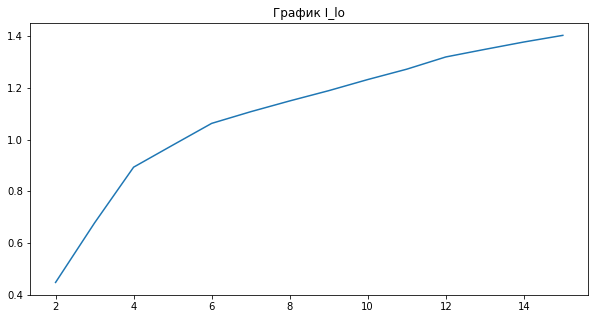

In [35]:
#Строим график 
t=range(2, len(I_lo)+2)
plt.figure(figsize = (10, 5))
plt.plot(t, I_lo)
plt.title("График I_lo")
#plt.ylabel('y(t)')
#plt.xlabel('t [sec]')
plt.show()

In [36]:
[I2,opt_A]=Algoritm_4(I_lo, 1.02)

aaa 0 1.5162868790005013
aaa 1 1.3182583314729002
aaa 2 1.0953301523296524
aaa 3 1.086301820228087
aaa 4 1.0425015177143016
aaa 5 1.0377237254544935
aaa 6 1.0345298194400512
aaa 7 1.0361859468221724
aaa 8 1.032602172585216
aaa 9 1.0371693870976073
aaa 10 1.0222205504752755
aaa 11 1.021164833915144
aaa 12 1.0187064557850665
12 1.0187064557850665 [14]


In [37]:
print(opt_A)

14


In [45]:
"""#Строим график 
t=range(2, len(I2)+2)
plt.figure(figsize = (10, 5))
plt.plot(t, I2)
plt.title("График I2")
#plt.ylabel('y(t)')
#plt.xlabel('t [sec]')
plt.show()"""

'#Строим график \nt=range(2, len(I2)+2)\nplt.figure(figsize = (10, 5))\nplt.plot(t, I2)\nplt.title("График I2")\n#plt.ylabel(\'y(t)\')\n#plt.xlabel(\'t [sec]\')\nplt.show()'

In [48]:
def AVT (opt_A, P_lo, Q_lo):
    Alphabet=opt_A
    Part_V=P_lo[opt_A-1]
    Q_V=Q_lo[opt_A-2]
    print('Alphabet = ', Alphabet, '\n')
    print('Partitioning location vector = ', Part_V, '\n')
    print('State set Q = ', Q_V, '\n')
    return (Alphabet, Part_V, Q_V)

In [49]:
#Получаем оптимальные значения алфавита, вектора разделения P и состояний Q
[Sigm, PLV, QV]=AVT(opt_A, P_lo, Q_lo)

Alphabet =  14 

Partitioning location vector =  [-6.938431216341175, -2.9585827615763662, -1.6960103702018925, -0.7667114866983269, -0.508312897138471, -0.41873253191734244, -0.29921683734871535, -0.14248082107720658, -0.005354636819352915, 0.13071533780228167, 0.2588652453363781, 0.39892696814043876, 0.7566938887030705, 2.2706189067334113, 6.908165016639937] 

State set Q =  ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n'] 



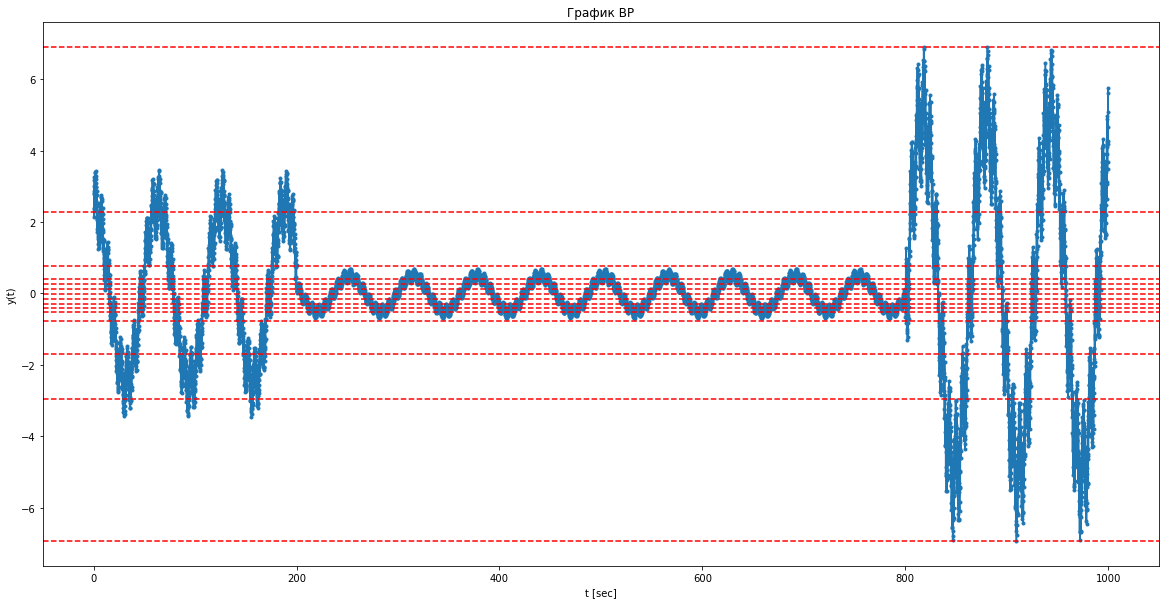

In [55]:
plt.figure(figsize = (20, 10))
plt.plot(xs, ys, marker='.')
for i in range (Sigm+1):
    plt.axhline(y=PLV[i], xmin=min(xs), xmax=max(xs), color="red", linestyle = '--')
plt.title("График ВР")
plt.ylabel('y(t)')
plt.xlabel('t [sec]')
plt.show()

In [231]:
string=TTS(ys, PLV, Sigm)

In [232]:
print(string)

nnnmnnnnnnnnnnnnnnnnnnnnnnnnmmnnnnmmmnnmmmmmnmmmmmmmmmmmmnmmmmnnmmmmnnnmmmnnnmmmmnnmmmmmnmmmmmmmmmmmmmmlklmmmkjkmmmlijlmmljklmmmlklmmmlllmmmmllmmmmkjlmmlighkljfddgihdccdffdcccdedcccdedcccdffdccdghecccfhfcccdgfccccddccbccccbbbcccbbbbbbbbbbbbbbbbbbbbbbbccbbbbccbbbbcccbbbcccbbbbccbbbbbbbbabbbbaaabbbaaaabbbaaabbbaabbbbbbbbbbbbbbccbbbbccbbbbbcbbbbbbbbbabbbbaaabbbbaabbbbaabbbbbbbbcbbbbccccbbcccccbccdccbcccccbbccccbbccccbbbcccbbbccccbbccdccccegdccdgjifdeilliffillkgfillkgegjlkgdehkkhddgjkiedfjlkhfgkmmkijlmmmllmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmnnmmmmnnnmmnnnnnmnnnnnmmnnnnmmnnnnmmmnnnmmmmnnmmmmnnmmmmnnnmmmnnnnmmnnnnnnnnnnnnnnnnnnnnnnnmmnnnnmmmnnmmmmmnmmmmmmmmmmmmnmmmmmnnmmmnnnmmmmnnnmmmnnnmmmmnmmmmmmmmmmmmmmlklmmmljklmmljjlmmlkjlmmmlklmmmmllmmmmllmmmmkjkmmliggjlkgddfihecccegdcccdedcccceeccccegdcccfhfcccehgdccdggdcccddccbccccbbbbccbbbbbbbbbbbbbbbbbbbbbbbccbbbbcccbbbcccbbbcccbbbbccbbbbbbbbabbbbbaabbbbaaabbbaaabbbbaabbbbbbbbbbbbbbcbbbbbccbbbbcbbbbbbbbbabbbbbaabbbbaabbbbbabbb

In [ ]:
#Дальше пока не работает

In [233]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots


In [234]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=xs, y=ys))
#for i in range (Sigm+1):
#fig.add_trace(go.Scatter(x=xs, y=PLV))
fig.show()

In [235]:
for i in range (len(Q_lo)):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-235-b2a79ff93ff8>, line 2)

In [236]:
string.find('bc')

217

In [261]:
def find_all_indexes(input_str, search_str): 
    l1 = []
    length = len(input_str)
    position = 0 
    while position < length: 
        try:
            i = input_str.index(search_str, position)
            #print(i)
            l1.append(i)
            #print(l1)
            position = i + 1
        except ValueError as ve1: 
            #print('lllllllll')
            #break
            # finally exception will be raised because all the indexes are found 
            return l1

In [238]:
print(QV)

['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n']


In [252]:
Gx=np.zeros(len(QV), dtype=list)
Gy=np.zeros(len(QV), dtype=list)
gg=np.zeros(len(QV), dtype=list)


#for i in range (len(QV)):
    #print(str(QV[i]))
    #gg[i]=find_all_indexes(string, str(QV[i]))


#print(len(QV))

#print(gg[13])

print(find_all_indexes(string, 'a'))




286
291
292
293
297
298
299
300
304
305
306
310
311
349
354
355
356
361
362
367
368
914
920
921
926
927
928
932
933
934
939
940
977
983
984
989
990
996
1542
1543
1548
1549
1550
1554
1555
1556
1560
1561
1562
1567
1568
1605
1611
1612
1617
1618
1624
8384
8385
8389
8390
8391
8392
8395
8396
8397
8398
8399
8400
8401
8402
8403
8404
8405
8406
8407
8408
8409
8410
8411
8412
8413
8414
8415
8416
8417
8418
8419
8420
8421
8422
8423
8424
8426
8427
8428
8429
8430
8433
8434
8435
8436
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
854

ValueError: substring not found

In [195]:
for i in range (len(QV)):
    Gx=[]
    Gy=[]
    #print(len(gg[i]))
    for j in range(len(gg[i])):
        Gx.append(xs[gg[i][j]])
        Gy.append(ys[gg[i][j]])


TypeError: object of type 'NoneType' has no len()

In [149]:
print(gg[2])

[166, 167, 172, 173, 174, 178, 179, 180, 184, 185, 186, 191, 192, 197, 198, 199, 203, 204, 205, 209, 210, 211, 212, 215, 216, 218, 219, 220, 221, 225, 226, 227, 251, 252, 257, 258, 263, 264, 265, 269, 270, 271, 276, 277, 326, 327, 332, 333, 339, 377, 382, 383, 384, 385, 388, 389, 390, 391, 392, 394, 395, 397, 398, 400, 401, 402, 403, 404, 407, 408, 409, 410, 413, 414, 415, 416, 420, 421, 422, 426, 427, 428, 429, 432, 433, 435, 436, 437, 438, 442, 443, 794, 795, 796, 800, 801, 802, 806, 807, 808, 809, 812, 813, 814, 815, 819, 820, 821, 825, 826, 827, 832, 833, 838, 839, 840, 843, 844, 846, 847, 848, 849, 854, 855, 879, 880, 885, 886, 887, 891, 892, 893, 897, 898, 899, 904, 905, 955, 961, 962, 967, 1005, 1006, 1010, 1011, 1012, 1013, 1016, 1017, 1018, 1019, 1020, 1022, 1023, 1025, 1026, 1028, 1029, 1030, 1031, 1032, 1035, 1036, 1037, 1038, 1042, 1043, 1044, 1048, 1049, 1050, 1054, 1055, 1056, 1057, 1060, 1061, 1063, 1064, 1065, 1066, 1070, 1071, 1072, 1422, 1423, 1424, 1428, 1429, 1430, 

In [141]:
print(Gy)

[-3.0579066121055556, -3.011152175252459, -3.334602484496277, -3.1984547471794254, -3.0326901530308357, -3.4233447276637827, -3.3892199066703608, -2.964916919179368, -3.2924707228883565, -3.3634764964951644, -2.9904951751593725, -2.9742054000616456, -3.1526015359181994, -2.9939640053025216, -2.9630674868277542, -3.199268238745818, -2.9716949967978135, -3.214979741242416, -3.0822930388063767, -3.0095599777794657, -2.9817628016762723, -3.0459859428413445, -3.2917869944156104, -3.27571929920138, -3.355027346567232, -3.4443734301661744, -3.0924548050658562, -3.2041819355497747, -3.3919148002882182, -3.115959358910464, -3.1499476462386222, -2.9805263422669412, -3.0081726324847007, -3.182434830186241, -3.0682386747352632, -3.1706868453538037, -3.16065725269629, -3.0357380880954103, -3.0016362834838257, -2.992673416928202, -3.2186787475125387, -3.3259532429524046, -2.9968928407803266, -3.2610245252346233, -3.4683447185384795, -3.211675622675062, -3.0969393858911407, -3.3875797880443863, -3.22

In [143]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=Gx[0], y=Gy[0]))
#for i in range (Sigm+1):
#fig.add_trace(go.Scatter(x=xs, y=PLV))
fig.show()

ValueError: 
    Invalid value of type 'numpy.float64' received for the 'x' property of scatter
        Received value: 28.6028602860286

    The 'x' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series

In [262]:
s = 'abaacdaaa12aa2a'
print(find_all_indexes(s, 'a')) 
print(find_all_indexes(s, 'aa'))

None
[2, 6, 7, 11]
